Задача аналитика в первую очередь - получать выводы основываясь на событиях игроков.
В тестовом задании вам предлагается датасет (в формате csv) в котором содержатся события для игры в жанре Match-3 для когорты пользователей, регистрировавшихся с 21 мая 2054 года в течении 7 дней.
Для выполнения задания можно использовать любые известные вам инструменты. Ответ на тестовое задание присылать в виде мини-отчета в формате pdf. Если считаете необходимым - можно дополнить любыми другими файлами.
Основные цели, проверяющиеся в ответе на тестовое задание:
    1. Получение метрик из событий
    2. Визуализация информации
    3. Составление выводов на основе имеющейся информации
    
Список событий

1. EventType:”Install” - регистрация
2. EventType:”Session” - старт сессии
3. EventType:”InitPurchase” - инициация покупки (нажатие на кнопку купить в игре и вызов системного магазина)
4. EventType:”Purchase” - совершение покупки
5. EventType:”FtueStep” - прохождение воронки входа

Описание параметров событий
Для всех событий список полей всегда одинаков. По смыслу значение поля EventParam в зависимости от типа события отличается, остальные универсальны для всех типов событий
    - EventTime - время совершения события в формате timestamp
    - EventType - тип события
    • Registered - дата регистрации игрока в формате timestamp
    • UserUID - уникальный идентификатор игрока
    • UserSource - источник инсталла (органика или траффик)
    • EventParam - меняется в зависимости от EventType
        ◦ EventType:”Install” - в параметры присылается название устройства на котором запущена игра
        ◦ EventType:”Session” - в параметр указывается порядковый номер сессии
        ◦ EventType:”InitPurchase” - в параметре присылается стоимость покупки в USD
        ◦ EventType:”Purchase” - так же в параметре указывается стоимость товара в USD
        ◦ EventType:”FtueStep” - в качестве параметра указывается номер шага в воронке входа
            ▪ 1 - регистрация игрока
            ▪ 2 - первый матч 3-х фишек
            ▪ 3 - второй матч 3-х фишек
            ▪ 4 - свободный ход (не ограничен туториалом)
            ▪ 5 - окно награды за уровень с кнопкой “далее”
            ▪ 6 - матч из 4-х фишек
            ▪ 7 - матч бонуса (уничтожить линию)
            ▪ 8 - конец уровня и конец туториала


Задание на позицию Game Analyst
    1. Составить мини-репорт по игре на основании имеющихся данных
    2. Предложить новые события, которые позволят вам как аналитику знать об игре больше
    3. Указать на слабые места в игре над которыми стоит поработать и предложить механики, которые могут решить найденные проблемы

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [6]:
data = pd.read_csv('testdataset - 2000 users.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127205 entries, 0 to 127204
Data columns (total 6 columns):
EventTime     127205 non-null int64
EventType     127205 non-null object
Registered    127205 non-null int64
UserUID       127205 non-null int64
UserSource    127205 non-null object
EventParam    127205 non-null object
dtypes: int64(3), object(3)
memory usage: 5.8+ MB


In [7]:
#трансформируем unix time в формат date
data['EventTime'] = pd.to_datetime(data['EventTime'], unit='s').dt.date
data['Registered'] = pd.to_datetime(data['Registered'], unit='s').dt.date

Разделим устройства на ios и Android

In [65]:
device = pd.Series(data[data.EventType == 'Install'].EventParam.unique())
type_of_device = device.str.contains('ip', case=False, regex=False)
device = pd.DataFrame(device)
device['ios'] = type_of_device
device.rename(columns={0:'device'}, inplace=True)


In [66]:
#создадим датасет с EventType = Install 
data_install = data[data.EventType == 'Install']
data_install.rename(columns={'EventParam':'device'}, inplace=True)
data_install = data_install.merge(device, how='left', on='device')
data_install.rename(columns={'ios':'device_system'}, inplace=True)
data_install['device_system'] = data_install['device_system'].map({False :'Android', True:'ios'}) 


In [74]:
#создадим датасет с EventType = Purchase 
data_purchase = data[data.EventType == 'Purchase']
data_purchase.rename(columns={'EventParam':'purchase'}, inplace=True)
data_purchase = data_purchase.merge(data_install[['device_system', 'UserUID']], how='left', on='UserUID')
data_purchase.purchase = pd.to_numeric(data_purchase.purchase)


/home/double_dee/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [68]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    """
    Создает подписи для bar
    """
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = float(p.get_height())
                ax.text(_x, _y, '{:.2f}'.format(value), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = float(p.get_width())
                ax.text(_x, _y, '{:.2%}'.format(value), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

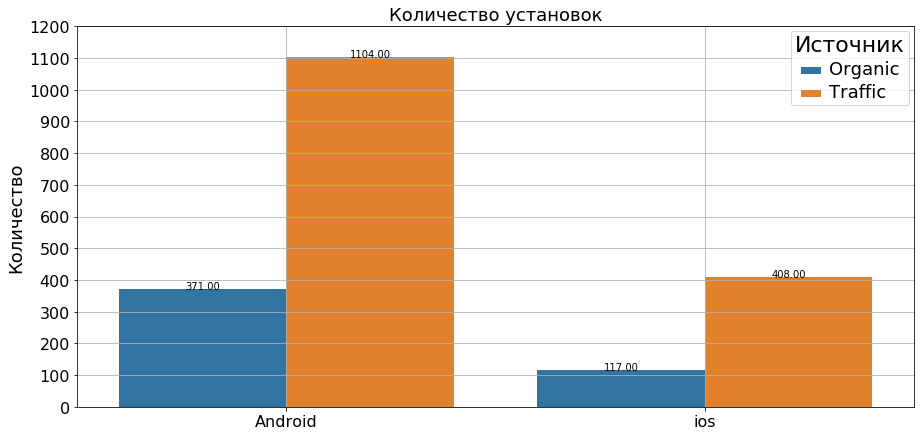

In [71]:
plt.rcParams['figure.figsize']=[15,7]
ax = sns.countplot(x='device_system', hue='UserSource', data=data_install, palette='tab10')
plt.grid()
plt.yticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200],fontsize='16');
plt.xticks(fontsize='16')
plt.title('Количество установок', fontsize=18)
plt.ylabel('Количество', fontsize=18)
plt.xlabel('')
plt.legend(title="Источник")
plt.setp(ax.get_legend().get_texts(), fontsize='18') 
plt.setp(ax.get_legend().get_title(), fontsize='22')
show_values_on_bars(ax, "v", 0.01)
plt.show()

In [75]:
#средний чек 
average_check = data_purchase.groupby('device_system').mean()['purchase']
average_check = pd.DataFrame(average_check)
average_check['system'] = average_check.index

(array([ 0.,  5., 10., 15., 20., 25.]), <a list of 6 Text yticklabel objects>)

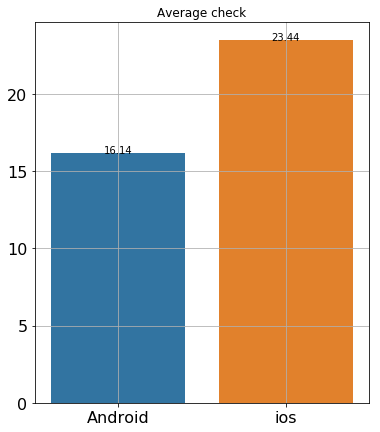

In [77]:
sns_average_check = sns.barplot(x='system', y='purchase', data=average_check, palette='tab10')
plt.rcParams['figure.figsize']=[6,7]
show_values_on_bars(sns_average_check, "v", 0.01)
plt.title('Average check')
plt.grid()
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize='16')
plt.yticks(fontsize='16')

In [14]:
data_device = data.merge(data_install[['device_system', 'UserUID']], how='left', on='UserUID')

In [15]:
paying_share_ios = data_purchase[data_purchase.device_system == 'ios'].UserUID.nunique() \
/ data_device[data_device.device_system == 'ios'].UserUID.nunique()

paying_share_android = data_purchase[data_purchase.device_system == 'Android'].UserUID.nunique() \
/ data_device[data_device.device_system == 'Android'].UserUID.nunique()

In [16]:
print('Доля платящих на ios: {:.2%}'.format(paying_share_ios))
print('Доля платящих на Android: {:.2%}'.format(paying_share_android))

Доля платящих на ios: 10.67%
Доля платящих на Android: 9.83%


Количество установок из платного траффика для устройств ios составлет 408, для устройств на Android 1104. Cредний чек для устройств на ios составляет 23.44, для устройств на Android 16.14. Доля платящих на ios: 10.67%, доля платящих на Android: 9.83%
Не зная цену закупки траффика можно предположить, что для увеличения общего среднего чека необходимо увеличить долю установок на ios, путем увеличения закупки траффика для ios. Чтобы повысить долю платящих в целом, возможно стоит добавить новый контент для покупки, изменить цены, провести скидочные акции.

Посчитаем конверсию в покупку

In [17]:
data_init_purchase = data[data.EventType == 'InitPurchase']
data_init_purchase = data_init_purchase.merge(
                     data_install[['device_system', 'UserUID']], how='left', on='UserUID'
                     )
data_init_purchase.rename(columns={'EventParam':'init_purchase'}, inplace=True)

In [18]:
conversion_buy_ios = data_purchase[data_purchase.device_system == 'ios'].shape[0] \
/ data_init_purchase[data_init_purchase.device_system == 'ios'].shape[0]

conversion_buy_android = data_purchase[data_purchase.device_system == 'Android'].shape[0] \
/ data_init_purchase[data_init_purchase.device_system == 'Android'].shape[0]

In [19]:
print('Конверсия в покупку для ios: {:.2%}'.format(conversion_buy_ios))
print('Конверсия в покупку для Android: {:.2%}'.format(conversion_buy_android))

Конверсия в покупку для ios: 0.61%
Конверсия в покупку для Android: 0.69%


Низкие показатели конверсии в покупку. Для увеличения конверсии необходимо проверить не возникает ли ошибок при попытке оплаты. Возможно стоит внести изменения в дизайн игрового магазина, количество отображаемых товаров, состав товаров. И провести А/Б тестирование. Так же можно создать дополнительные шаги между инициализацией покупки и самой покупкой, построить воронку и отследить на каком этапе происходит отвал пользователей. 

In [32]:
#создадим датасет с EventType = FtueStep 
data_flue_step = data[data.EventType == 'FtueStep']
data_flue_step = data_flue_step.rename(columns={'EventParam':'FlueStep'})


In [21]:
#создадим датасет с пользовтаелями кто попытался зарегистрировваться
data_step_1_users = data_flue_step[data_flue_step['FlueStep'] == '1']

In [22]:
count_started_users = np.unique(data_step_1_users['UserUID']).shape[0]
data_funel = pd.DataFrame(data_flue_step.groupby('FlueStep').nunique()['UserUID'])
data_funel['uid_cnt'] = data_funel.UserUID
data_funel['Step'] = data_funel.index
#посчитаем долю прошедших уровень от новых пользователей
data_funel['share_of_new_users'] = data_funel.uid_cnt/count_started_users


Text(0.5, 0, '')

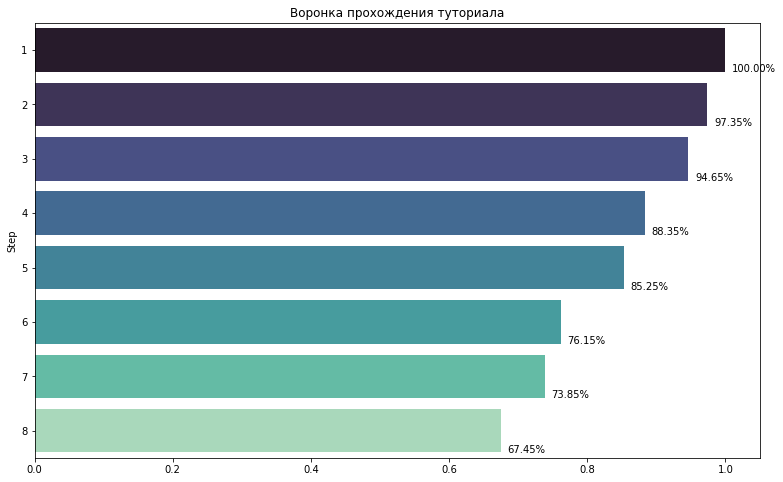

In [23]:
plt.rcParams['figure.figsize']=[13,8]
sns_t = sns.barplot(x='share_of_new_users', y='Step',orient='h', data=data_funel, palette='mako');
plt.title('Воронка прохождения туториала')
show_values_on_bars(sns_t, "h", 0.01)
plt.xlabel('')

Видим, что наибольший отвал происходит между 5 и 6 шагом. Возможно необходимо ввести дополнительные шаги между 5 и 6 шагом, увеличить размер награды, изменить кнопку "далее", чтобы отследить и устранить причину отвала, что в свою очередь увеличит общую конверсию в прохождение туториала. Так же значительный отвал между 7 и 8 шагом, тут можно попробовать снизить сложность шага "матч бонуса". Между 3 и 4 шагом, стоит посмотреть, что делает пользователь (куда кликает, заходит), чтобы понять почему происходит отвал. В целом стоит увеличить количество шагов для отслеживания прохождения туториала чтобы отследить максимум событий которые приводят к отвалу, включить невидимые шаги (когда подгружаются текстуры, грузится графика)

In [8]:
#создадим датасет с EventType = Session 
data_session = data[data.EventType == 'Session']
data_session.rename(columns={'EventParam':'session'}, inplace=True)


/home/double_dee/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Посчитаем DAU

In [129]:
data_dau = pd.DataFrame(data_session.groupby('EventTime').nunique()['UserUID'])
data_dau['Event_Time'] = data_dau.index
data_dau.rename(columns={'UserUID':'DayActiveUsers'}, inplace=True)
data_dau['Event_Time'] = data_dau['Event_Time'].astype('str')

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 <a list of 8 Text yticklabel objects>)

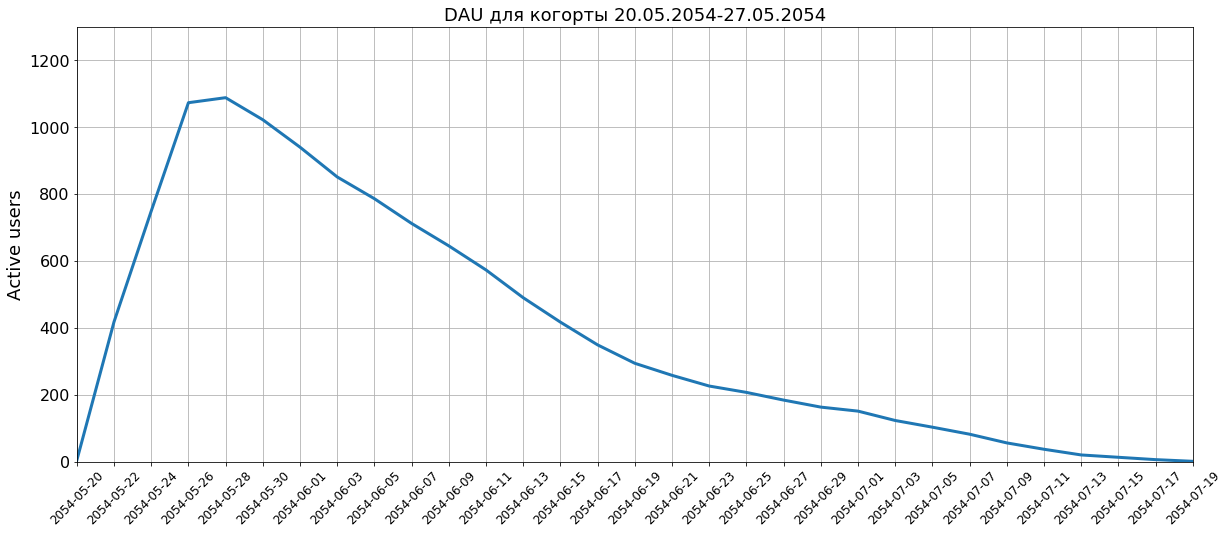

In [176]:
ax = sns.lineplot(x=data_dau['Event_Time'][::2], y='DayActiveUsers',data = data_dau, linewidth = 3.0)
plt.rcParams['figure.figsize']=[20,8]
plt.grid()
plt.title('DAU для когорты 20.05.2054-27.05.2054', fontsize=18)
ax.set_xticklabels(data_dau['Event_Time'][::2], rotation = 45);
plt.ylim(0, 1300)
plt.xlim('2054-05-20', '2054-07-19')
plt.ylabel('Active users', fontsize=18)
plt.xlabel('')
plt.xticks(fontsize='12')
plt.yticks(fontsize='16')


Посчитаем Gross для когорты 20.05.2054-27.05.2054. Поскольку в условии нет никаких данных о комиссии магазина в котором игра размещается, Gross будем считать без учета этой комиссии.

In [127]:
data_gross = pd.DataFrame(data_purchase.groupby('EventTime').sum()['purchase'])
data_gross['Event_Time'] = data_gross.index
data_gross.rename(columns={'purchase':'gross'}, inplace=True)
data_gross['Event_Time'] = data_gross['Event_Time'].astype('str')

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 <a list of 10 Text yticklabel objects>)

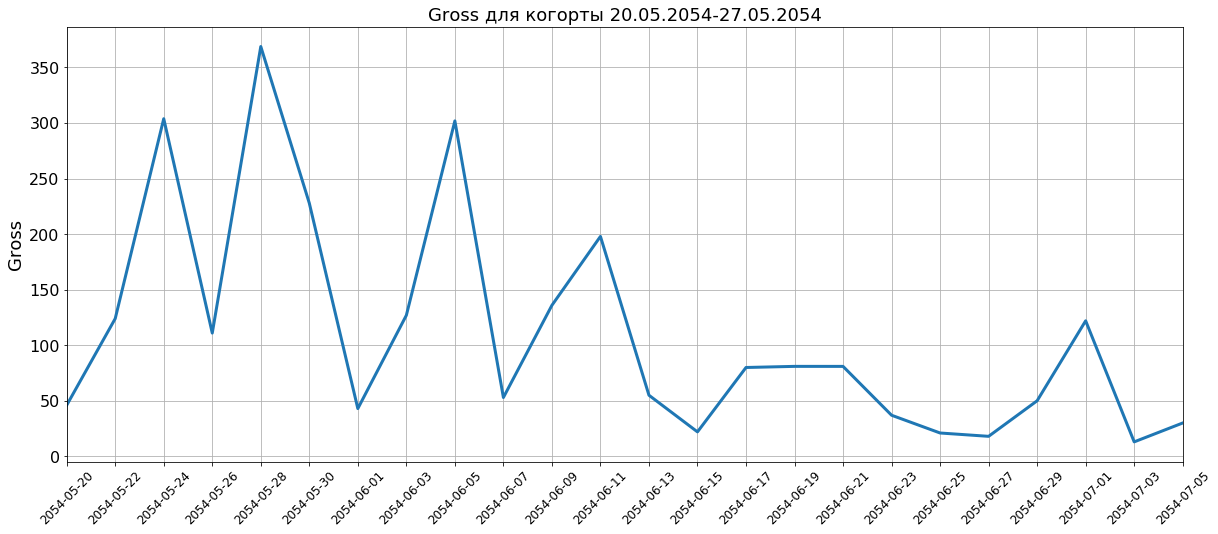

In [206]:
ax = sns.lineplot(x=data_gross['Event_Time'][::2], y='gross',data = data_gross, linewidth = 3.0)
plt.rcParams['figure.figsize']=[20,8]
plt.grid()
plt.title('Gross для когорты 20.05.2054-27.05.2054', fontsize=18)
ax.set_xticklabels(data_dau['Event_Time'][::2], rotation = 45);
plt.xlim('2054-05-22', '2054-07-17')
plt.ylabel('Gross', fontsize=18)
plt.xlabel('')
plt.xticks(fontsize='12')
plt.yticks(fontsize='16')

Посчитаем ARPU для когорты 20.05.2054-27.05.2054

In [131]:
data_arpu = data_gross.merge(data_dau['DayActiveUsers'], how='left', on='EventTime')
data_arpu['Arpu'] = data_arpu['gross']/data_arpu['DayActiveUsers']

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 8 Text yticklabel objects>)

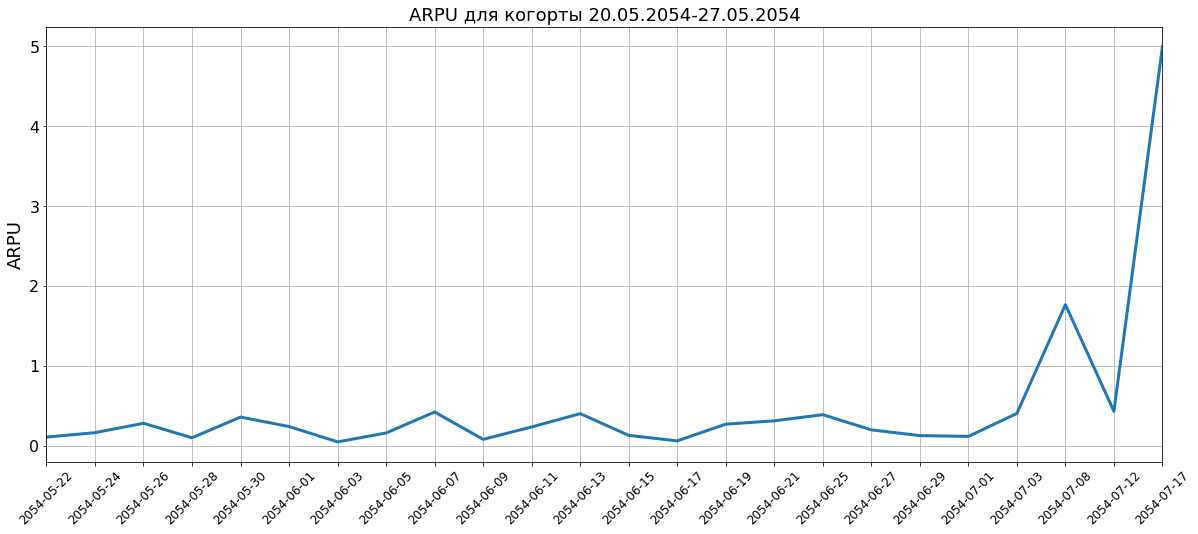

In [200]:
ax = sns.lineplot(x=data_arpu['Event_Time'][::2], y='Arpu',data = data_arpu, linewidth = 3.0)
plt.rcParams['figure.figsize']=[20,8]
plt.grid()
plt.title('ARPU для когорты 20.05.2054-27.05.2054', fontsize=18)
ax.set_xticklabels(data_arpu['Event_Time'][::2], rotation = 45);
plt.xlim('2054-05-22', '2054-07-17')
plt.ylabel('ARPU', fontsize=18)
plt.xlabel('')
plt.xticks(fontsize='12')
plt.yticks(fontsize='16')

До 2054-07-01 метрика ARPU стабильна, после замечаем резкий рост, это можно объяснить посмотрев на график DAU. После 2054-07-01 количество активных пользователей значительно меньше чем до этого периода, и продолжает уменьшаться, следовательно высокий показатель ARPU не приносит больше Gross, что видно на графике Gross. Чтобы повысить ARPU следует вводить новый привлекательный контент, больше игроков начнет платить, а те кто платил раньше будут платить боьше.

Посчитаем календарный retention

In [88]:
#сгруппируем пользователей по когортам
data_session['Registered'] = data_session['Registered'].astype('str')
grouped = data_session.groupby(['Registered', 'EventTime'])
cohorts = grouped.agg({'UserUID': pd.Series.nunique, 'session':pd.Series.count})
cohorts.rename(columns={'UserUID': 'TotalUsers', 'session':'TotalSession'}, inplace = True)


/home/double_dee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [87]:
def cohort_period(df): 
    df['CohortPeriod'] = np.arange(len(df)) + 0 # отсчет с 0
    return df

In [89]:
cohorts = cohorts.groupby(level=0).apply(cohort_period)


In [90]:
# переиндексируем DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['Registered','CohortPeriod'], inplace=True)
# создадим ряд содержаший размер каждой когорты Registered
cohort_group_size = cohorts['TotalUsers'].groupby(level=1).first()

In [91]:
user_retention = cohorts['TotalUsers'].unstack(1).divide(cohorts['TotalUsers'].unstack(1)[0], axis=0)


Text(0.5, 57.5, '')

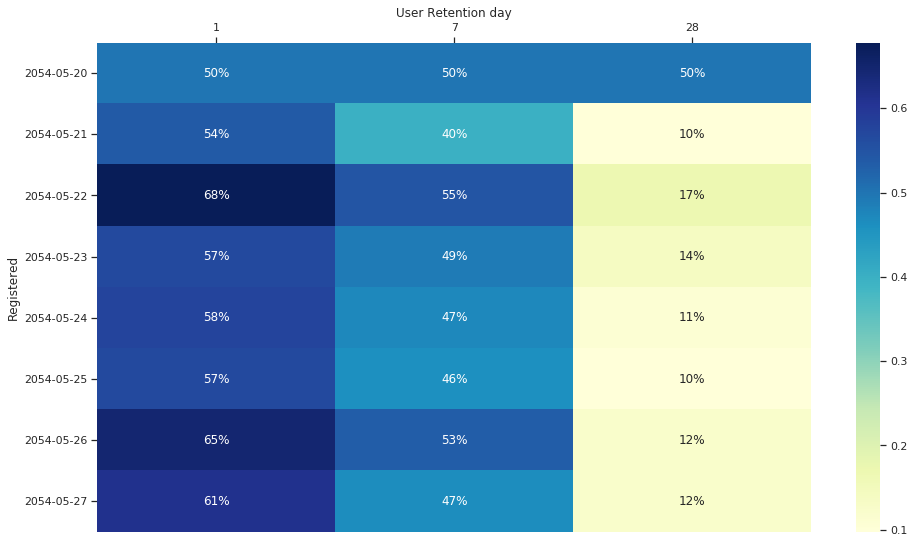

In [38]:
sns.set(style='ticks')
plt.rcParams['figure.figsize']=[16,9]
plt.title('User Retention day')
plt.yticks(rotation='horizontal')
ax = sns.heatmap(user_retention[[1, 7, 28]]
            , mask=user_retention[[1, 7, 28]].isnull(), annot=True, fmt='.0%', cmap="YlGnBu")
ax.xaxis.set_ticks_position('top')
plt.xlabel('')

Когорта 2054.05.20 состоит из 4 пользователей, поэтому данные retention по этой когорте отличаются от остальных когорт

Посчитаем календарный retention для когорты 21.05.2054-28.05.2054

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 11 Text yticklabel objects>)

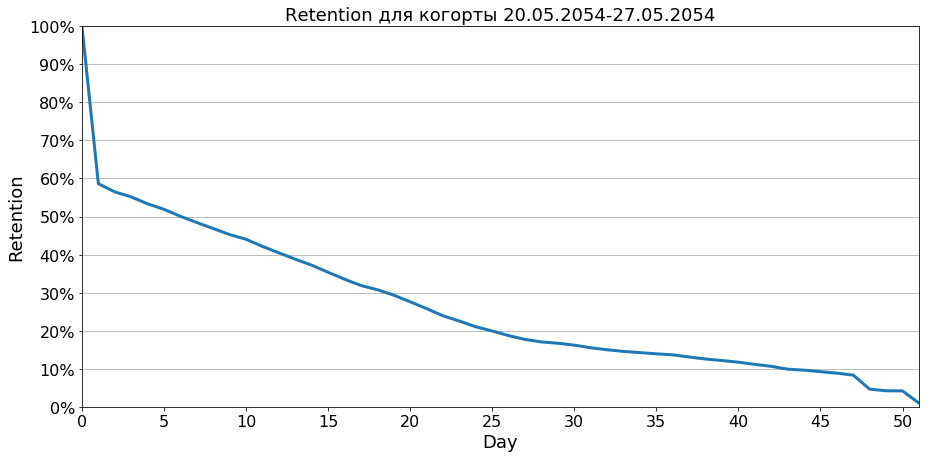

In [196]:
retention_mean = user_retention.mean(axis=0)
plt.rcParams['figure.figsize']=[15,7]
ax = sns.lineplot(data = retention_mean, linewidth = 3.0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks([i for i in range(0, user_retention.shape[1], 5)]);
plt.grid(axis='y')
plt.xlabel('Day', fontsize=18)
plt.ylabel('Retention', fontsize=18)
plt.xlim(0, 51)
plt.ylim(0, 1)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]);
plt.title('Retention для когорты 20.05.2054-27.05.2054', fontsize=18)
plt.xticks(fontsize='16')
plt.yticks(fontsize='16')

Для увеличения retention возможно добавить бонусы за каждодневный вход в игру, добавить ежедневные простые задания. Добавить долгосрочные цели в игре. Отправлять push уведомления игроку, если он долго не заходил в игру. Минимизировать количество багов и ошибок в игровом процессе